In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from sklearn.utils.extmath import randomized_svd as rsvd
rsvd.__name__ = "rsvd"
T = time.perf_counter()

In [2]:
def svd_rank_experiment(X, func, ranks, *args, **kwargs):
    # No randomness, so no need for recomputation
    to = []
    eo = []
    
    t0 = time.perf_counter()
    U, s, Vh = func(X)
    t1 = time.perf_counter()
    
    for k in tqdm.tqdm(ranks):
        X_ = U[:, :k] * s[:k] @ Vh[:k]
        er = np.linalg.norm(X - X_)
        to.append(t1 - t0)
        eo.append(er)

    to = np.array(to).reshape(-1, 1)
    eo = np.array(eo).reshape(-1, 1)
    
    return to, eo

def rsvd_rank_experiment(X, func, ranks, n_trials: int = 5):
    # Run experiment over many ranks
    to = []
    eo = []
    
    for k in tqdm.tqdm(ranks):
        ti = []
        ei = []
        
        for trial in range(n_trials):
            t0 = time.perf_counter()
            U, s, Vh = func(X, k)
            t1 = time.perf_counter()
            
            X_ = U[:, :k] * s[:k] @ Vh[:k]
            er = np.linalg.norm(X - X_)

            ti.append(t1 - t0)
            ei.append(er)
        
        to.append(ti)
        eo.append(ei)

    to = np.array(to)
    eo = np.array(eo)
    
    return to, eo

def rank_metrics(ranks, times, errors, svd_times):
    metrics = {}
    metrics["rank"] = ranks
    metrics["runtime_avg"] = times.mean(axis=1)
    metrics["runtime_std"] = times.var(axis=1)
    metrics["$||X-U_k\\Sigma_k V_k^T||_2$_avg"] = errors.mean(axis=1)
    metrics["$||X-U_k\\Sigma_k V_k^T||_2$_std"] = errors.var(axis=1)
    metrics["speedup_avg"] = svd_times.mean(axis=1) / metrics["runtime_avg"]
    metrics["speedup_std"] = 0 * metrics["speedup_avg"]
    return metrics

def random_matrix(m, n, singular_values):
    k = min(m, n)
    s = singular_values
    U = ortho_group.rvs(m)
    Vh = ortho_group.rvs(n)
    return U[:, :k] * s[:k] @ Vh[:k]

## Experiment: Low-rank approximation of a matrix

In [3]:
def experiment(m: int, n: int, s: np.array, ranks: list, n_trials: int, hparams: list):    
    results = []
    
    X = random_matrix(m, n, s)
    print("Matrix:", X.shape, "ranks:", ranks, "n_trials:", n_trials)
     
    # Exact 
    f = np.linalg.svd
    func = lambda x: f(x, full_matrices=False)
    svd_times, errors = svd_rank_experiment(X, func, ranks, n_trials)
    
    metrics = {}
    metrics["name"] = [f.__name__] * len(ranks)
    metrics = {**metrics, **rank_metrics(ranks, svd_times, errors, svd_times)}
    results.append(metrics)
    
    # Approximate    
    for hparam in hparams:
        f = rsvd
        func = lambda x, k: f(x, k, **hparam)
        times, errors = rsvd_rank_experiment(X, func, ranks, n_trials) 
        label = ",".join([f"{k}={v}" for k, v in hparam.items()])
        
        metrics = {}
        metrics["name"] = [f.__name__ + f" ({label})"] * len(ranks)
        metrics = {**metrics, **rank_metrics(ranks, times, errors, svd_times)}
        results.append(metrics)
    
    return results

def plot_experiment(
    results: list, 
    measures: list, 
    singular_values: np.array, 
    dist: str, 
    size: list, 
    figsize=(24, 4)
):
    m, n = size
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    for i, measure in enumerate(measures, 1):
        for j, metrics in enumerate(results):
            ranks = metrics["rank"]
            if "$" in measure:
                ax[i].errorbar(
                    ranks, 
                    metrics[f"{measure}_avg"], 
                    metrics[f"{measure}_std"], 
                    label=metrics["name"][0], 
                    alpha=1/(j+1)
                )
                ax[i].scatter(ranks, metrics[f"{measure}_avg"])
            else:
                width = 1 / (len(results) + 1)
                ax[i].bar(
                    np.arange(len(ranks)) + width * j, 
                    metrics[f"{measure}_avg"],  
                    label=metrics["name"][0], 
                    tick_label=ranks,
                    width=width
                )
        ax[i].set_title(f"$k_{{rank}}$ approximation of $X \\sim {dist} \\in R^{{{m}x{n}}}$")
        ax[i].set_xlabel("k")
        ax[i].set_ylabel(measure if measure != "runtime" else "runtime (s)")
    ax[i].legend()
    
    # Plot of singular values
    ax[0].plot(singular_values)
    ax[0].scatter(ranks, singular_values[ranks - 1])
    ax[0].set_title(f"Singular values of $X \\sim {dist} \\in R^{{{m}x{n}}}$")
    ax[0].set_xlabel("k")
    ax[0].set_ylabel("$\\sigma$")
    
    plt.show()

### 1.1: Square Matrix $\to m=n$

In [4]:
m = n = 2000
r = min(m, n)
num = 5
top = .05
ranks = np.linspace(int(r / num), r, num=num, dtype=int)
n_trials = 1 # TODO: Possibly can remove since variance is insignificant
rsvd_hparams = [
    {"n_oversamples": 0, "n_iter": 0},
    {"n_oversamples": 10, "n_iter": 0},
    {"n_oversamples": 0, "n_iter": 1},
] # control speed-accuracy tradeoff

In [5]:
%%time

config = {}
config["m=n"] = {}
config["m=n"]["size"] = (m, n)

results = {}
singular_values = {}

np.random.seed(42)
s = singular_values["I"] = np.ones(r)
results["I"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

np.random.seed(42)    
s = singular_values["Exp"] = np.sort(np.random.standard_exponential(r))[::-1]
results["Exp"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

np.random.seed(42)
k = int(r * top)
ranks = (ranks / (r / k)).astype(int)
s = np.sort(np.random.standard_exponential(r))[::-1]
s[k:] = 0
s = singular_values[f"Exp (k_{{{k}}})"] = s
results[f"Exp (k_{{{k}}})"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

config["m=n"]["results"] = results
config["m=n"]["singular_values"] = singular_values

Matrix: (2000, 2000) ranks: [ 400  800 1200 1600 2000] n_trials: 1


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


[ 400  800 1200 1600 2000] 2000 

Matrix: (2000, 2000) ranks: [ 400  800 1200 1600 2000] n_trials: 1


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


[ 400  800 1200 1600 2000] 2000 

Matrix: (2000, 2000) ranks: [ 20  40  60  80 100] n_trials: 1


100%|██████████| 5/5 [00:00<00:00, 30.86it/s]

[ 20  40  60  80 100] 100 

CPU times: user 1min 30s, sys: 5.7 s, total: 1min 35s
Wall time: 42.8 s


### 1.2: Tall Matrix $\to m>n$

In [6]:
m, n = 4000, 1000
r = min(m, n)
num = 5
top = .05
ranks = np.linspace(int(r / num), r, num=num, dtype=int)
n_trials = 1 # TODO: Possibly can remove since variance is insignificant
rsvd_hparams = [
    {"n_oversamples": 0, "n_iter": 0},
    {"n_oversamples": 10, "n_iter": 0},
    {"n_oversamples": 0, "n_iter": 1},
] # control speed-accuracy tradeoff

In [7]:
%%time

config["m>n"] = {}
config["m>n"]["size"] = (m, n)

results = {}
singular_values = {}

np.random.seed(42)
s = singular_values["I"] = np.ones(r)
results["I"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

np.random.seed(42)    
s = singular_values["Exp"] = np.sort(np.random.standard_exponential(r))[::-1]
results["Exp"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

np.random.seed(42)
k = int(r * top)
ranks = (ranks / (r / k)).astype(int)
s = np.sort(np.random.standard_exponential(r))[::-1]
s[k:] = 0
s = singular_values[f"Exp (k_{{{k}}})"] = s
results[f"Exp (k_{{{k}}})"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

config["m>n"]["results"] = results
config["m>n"]["singular_values"] = singular_values

Matrix: (4000, 1000) ranks: [ 200  400  600  800 1000] n_trials: 1


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


[ 200  400  600  800 1000] 1000 

Matrix: (4000, 1000) ranks: [ 200  400  600  800 1000] n_trials: 1


100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


[ 200  400  600  800 1000] 1000 

Matrix: (4000, 1000) ranks: [10 20 30 40 50] n_trials: 1


100%|██████████| 5/5 [00:00<00:00, 45.46it/s]

[10 20 30 40 50] 50 

CPU times: user 20.8 s, sys: 2.94 s, total: 23.7 s
Wall time: 19.6 s


### 1.3: Fat Matrix $\to m<n$

In [8]:
m, n = 1000, 4000
r = min(m, n)
num = 5
top = .05
ranks = np.linspace(int(r / num), r, num=num, dtype=int)
n_trials = 1 # TODO: Possibly can remove since variance is insignificant
rsvd_hparams = [
    {"n_oversamples": 0, "n_iter": 0},
    {"n_oversamples": 10, "n_iter": 0},
    {"n_oversamples": 0, "n_iter": 1},
] # control speed-accuracy tradeoff

In [9]:
%%time

config["m<n"] = {}
config["m<n"]["size"] = (m, n)

results = {}
singular_values = {}

np.random.seed(42)
s = singular_values["I"] = np.ones(r)
results["I"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

np.random.seed(42)    
s = singular_values["Exp"] = np.sort(np.random.standard_exponential(r))[::-1]
results["Exp"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

np.random.seed(42)
k = int(r * top)
ranks = (ranks / (r / k)).astype(int)
s = np.sort(np.random.standard_exponential(r))[::-1]
s[k:] = 0
s = singular_values[f"Exp (k_{{{k}}})"] = s
results[f"Exp (k_{{{k}}})"] = experiment(m, n, s, ranks, n_trials, rsvd_hparams)
print(ranks, sum(s>0), "\n")

config["m<n"]["results"] = results
config["m<n"]["singular_values"] = singular_values

Matrix: (1000, 4000) ranks: [ 200  400  600  800 1000] n_trials: 1


100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


[ 200  400  600  800 1000] 1000 

Matrix: (1000, 4000) ranks: [ 200  400  600  800 1000] n_trials: 1


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


[ 200  400  600  800 1000] 1000 

Matrix: (1000, 4000) ranks: [10 20 30 40 50] n_trials: 1


100%|██████████| 5/5 [00:00<00:00, 48.67it/s]

[10 20 30 40 50] 50 

CPU times: user 20.8 s, sys: 2.9 s, total: 23.7 s
Wall time: 19.4 s


### 1.4: Plot results

# $m=n$

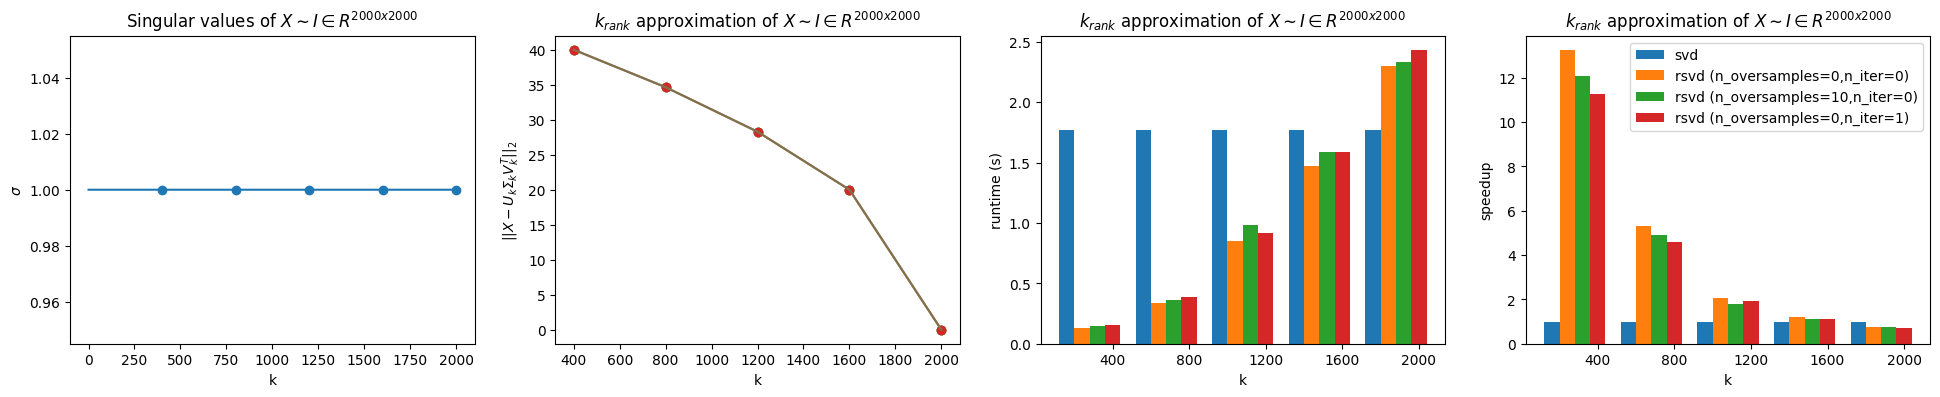

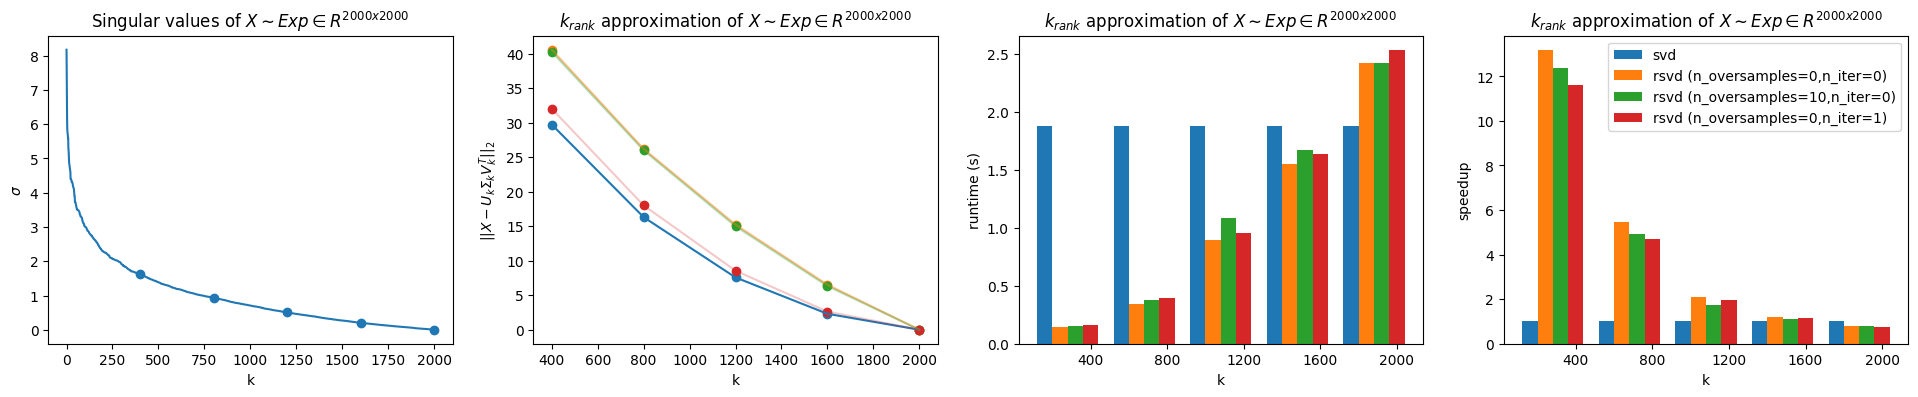

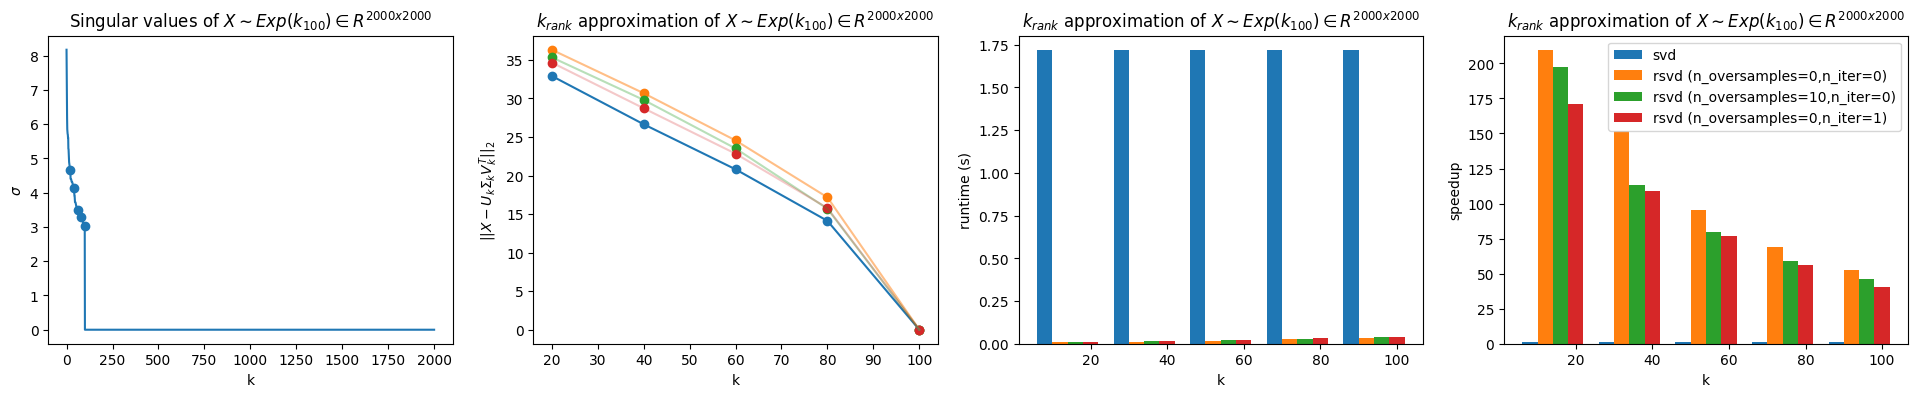

---

# $m>n$

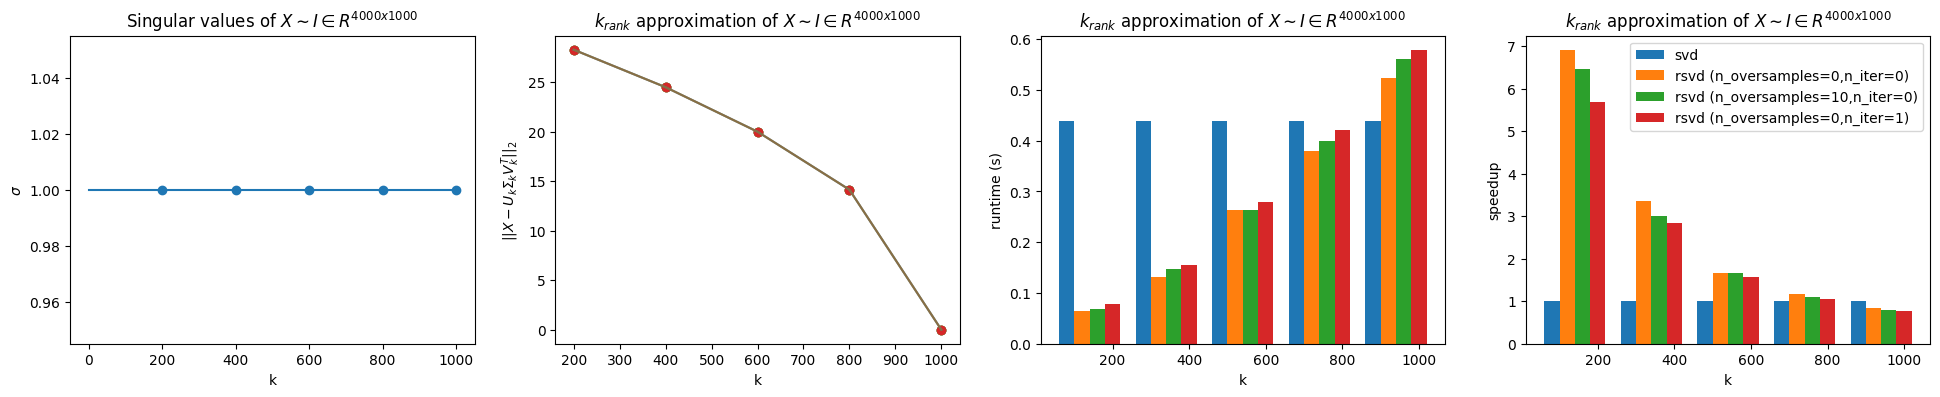

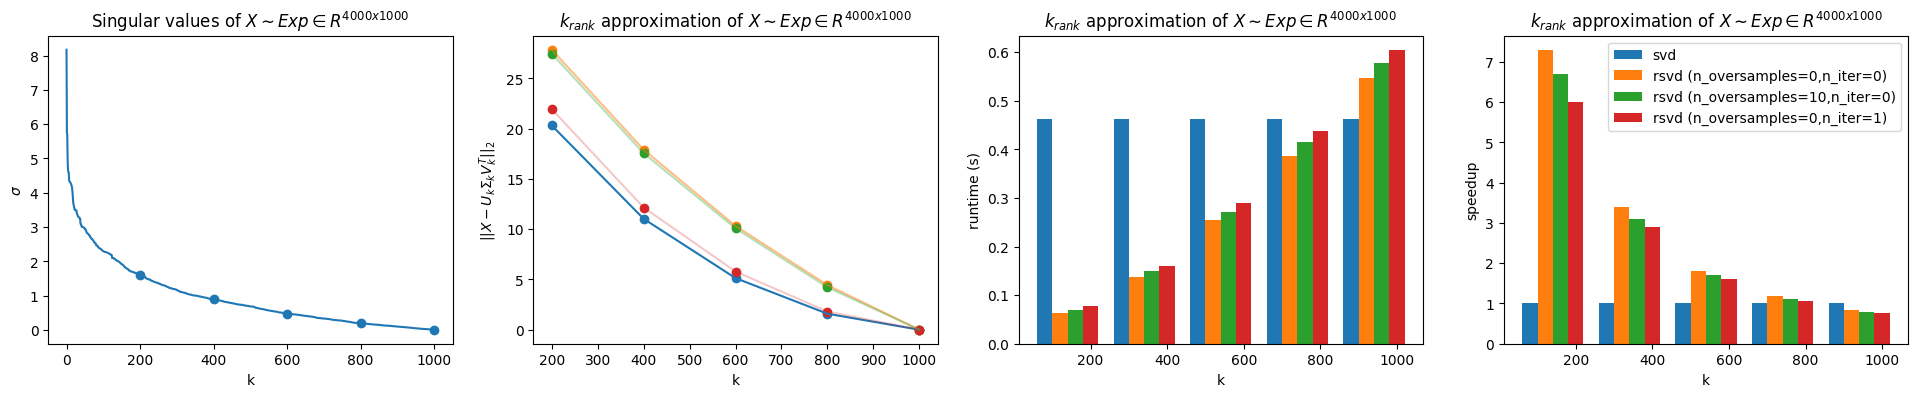

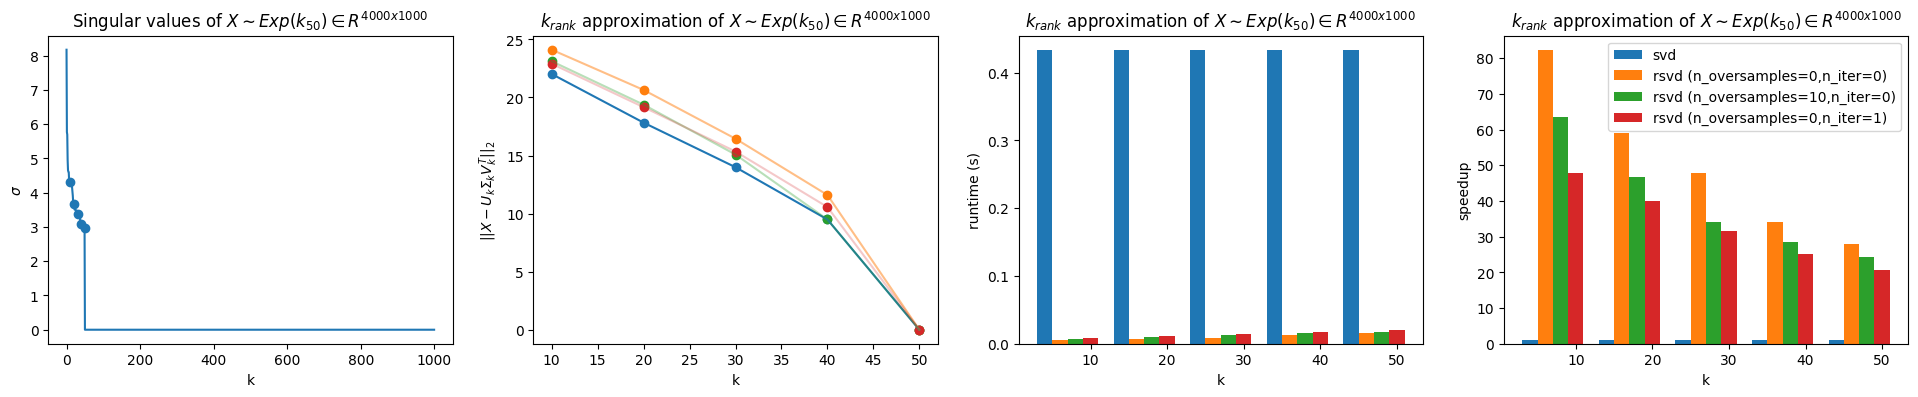

---

# $m<n$

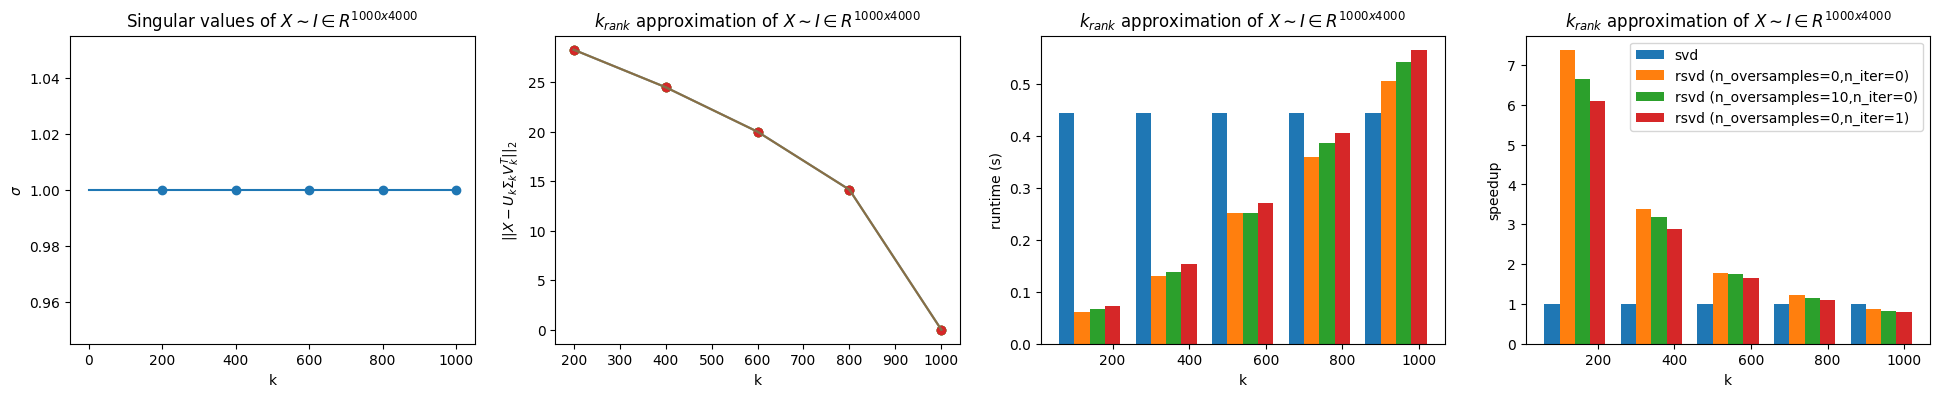

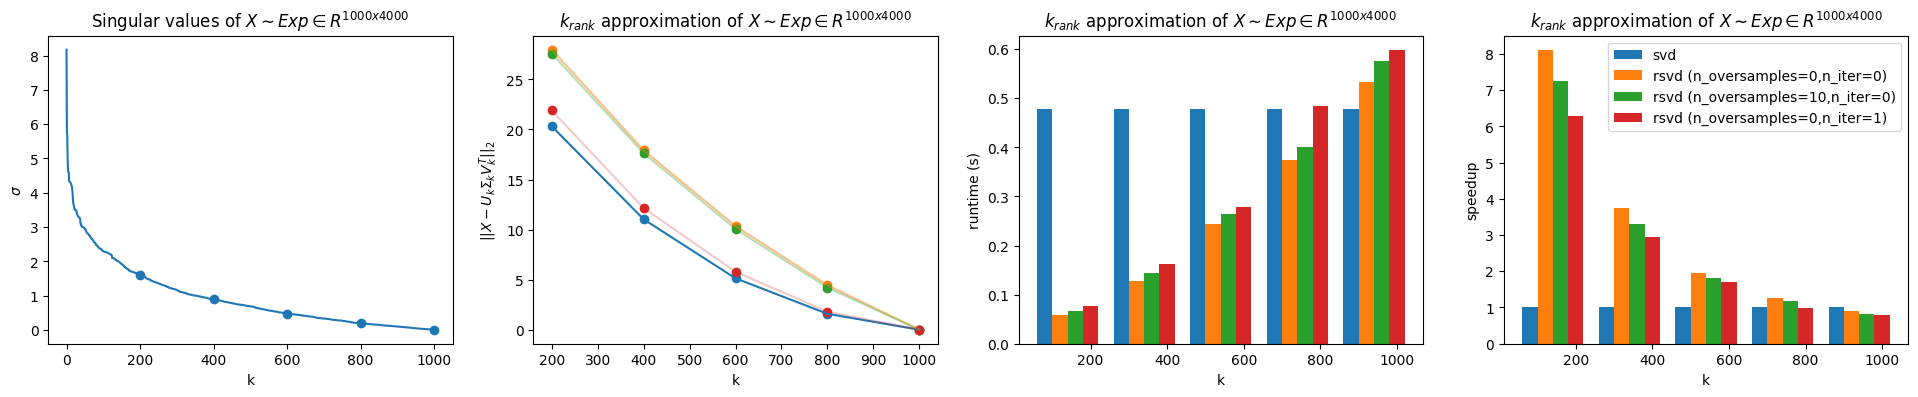

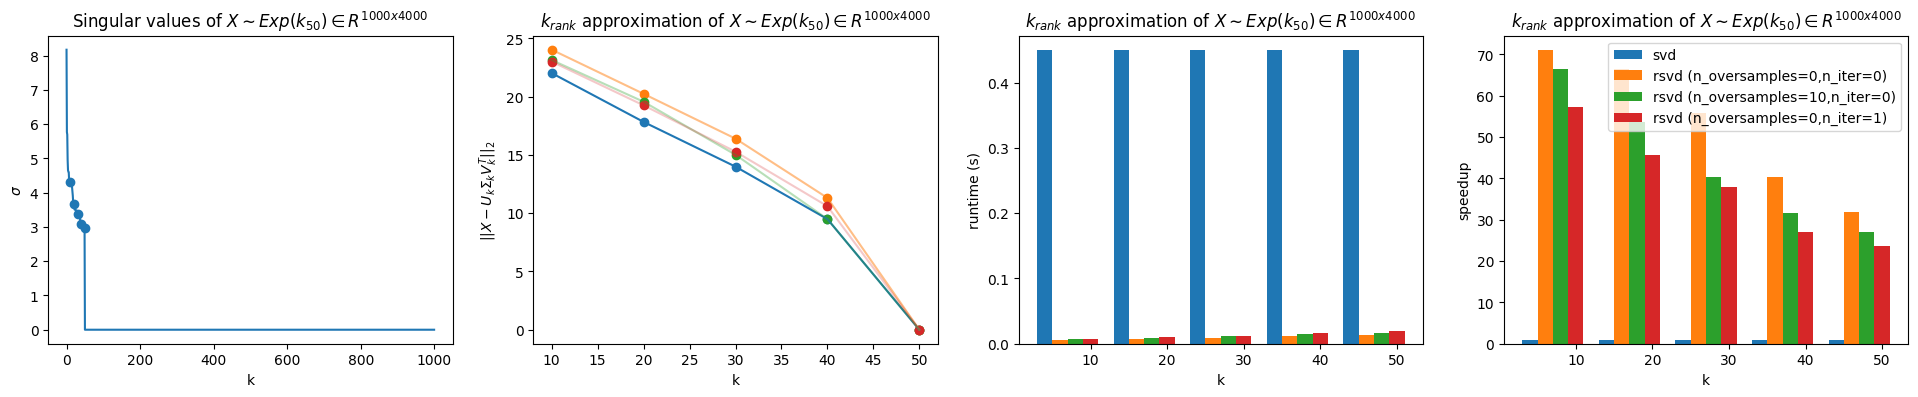

---

__Total running time of the script: 84.064 seconds__

In [10]:
from IPython.display import Markdown

measures = ["$||X-U_k\\Sigma_k V_k^T||_2$", "runtime", "speedup"]

for inequality in config:
    title = f"# ${inequality}$"
    display(Markdown(title))
    
    size = config[inequality]["size"]
    results = config[inequality]["results"]
    singular_values = config[inequality]["singular_values"]
    names = results.keys()
    
    for name in names:
        result = results[name]
        singular_value = singular_values[name]
        plot_experiment(result, measures, singular_value, name, size)

    display(Markdown("---"))    
Markdown(f"__Total running time of the script: {round(time.perf_counter() - T, 3)} seconds__")